# Libraries Installation

In [1]:
!pip install -q torch==2.9.0 cuda-bindings==12.9.5 "opentelemetry-api<=1.37.0" "opentelemetry-sdk<=1.37.0" unsloth trl peft accelerate bitsandbytes  deepeval datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.7/405.7 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.1/423.1 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 818.3/818.3 kB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# I. Financial Sentiment Classification

**Dataset**: TimKoornstra/financial-tweets-sentiment<br>
**Model**: Qwen/Qwen3-4B-Instruct

## 1. Setup

In [2]:
import torch
import random
import numpy as np
from collections import Counter

SEED = 47
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

GPU: NVIDIA A100-SXM4-80GB
Memory: 85.2 GB


## 2. Load Dataset

In [3]:
from datasets import load_dataset

# Using a Parquet-based mirror (ahmedrachid/financial_phrasebank) as script-based loading is no longer supported in datasets>=3.0
dataset = load_dataset("TimKoornstra/financial-tweets-sentiment", split="train")

print(f"Total Samples: {len(dataset)}")
print(f"Columns: {dataset.column_names}")
print("Example:")
print(f"\t{dataset[0]}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/2.65M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/38091 [00:00<?, ? examples/s]

Total Samples: 38091
Columns: ['tweet', 'sentiment', 'url']
Example:
	{'tweet': '$BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT', 'sentiment': 2, 'url': 'https://huggingface.co/datasets/zeroshot/twitter-financial-news-sentiment'}


In [4]:
# Label Distribution
# Standard mapping for zeroshot/twitter-financial-news-sentiment is 0: Bearish, 1: Bullish, 2: Neutral
LABEL_MAP = {0: "neutral", 1: "bullish", 2: "bearish"}

label_counts = Counter(dataset["sentiment"])
print("Label distribution")
for label_id, count in sorted(label_counts.items()):
  print(f"\t{LABEL_MAP[label_id]:>8}: {count} ({100*count/len(dataset):.1f}%)")

Label distribution
	 neutral: 12181 (32.0%)
	 bullish: 17368 (45.6%)
	 bearish: 8542 (22.4%)


In [5]:
for label_id, label_name in LABEL_MAP.items():
  examples = [ex for ex in dataset if ex["sentiment"] == label_id][:2]
  print(f"\n====== {label_name.upper()} ======")
  for ex in examples:
    print(f"\t{ex["tweet"][:120]}")


====== NEUTRAL ======
	$LB - MKM Partners puts a number on Victoria's Secret https://t.co/VSzHLqLBgE
	$WING - Baird returns to Wingstop bull camp https://t.co/KfPaweOVgo

====== BULLISH ======
	$ALTG: Dougherty & Company starts at Buy
	$AMD - AMD's Navi shows strong adoption - BofA https://t.co/WnCksfl1gX

====== BEARISH ======
	$BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT
	$CCL $RCL - Nomura points to bookings weakness at Carnival and Royal Caribbean https://t.co/yGjpT2ReD3


In [6]:
# Creating Train/Test Split
split = dataset.train_test_split(test_size=0.2, seed=SEED, stratify_by_column="sentiment")
train_dataset = split["train"]
test_dataset = split["test"]

print(f"Train: {len(train_dataset)} | Test: {len(test_dataset)}")

# Verifying stratification of dataset
train_dist = Counter(train_dataset["sentiment"])
test_dist = Counter(test_dataset["sentiment"])
print(f"\nTrain Distribution: { {LABEL_MAP[k]: v for k,v in sorted(train_dist.items())} }")
print(f"Test Distribution: { {LABEL_MAP[k]: v for k,v in sorted(test_dist.items())} }")

Train: 30472 | Test: 7619

Train Distribution: {'neutral': 9745, 'bullish': 13894, 'bearish': 6833}
Test Distribution: {'neutral': 2436, 'bullish': 3474, 'bearish': 1709}


# 3. Load Model and Tokenizer

In [7]:
from unsloth import FastLanguageModel

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [ ]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="Qwen/Qwen3-4B-Instruct-2507",
    max_seq_length=512,
    load_in_4bit=False,
    load_in_8bit=True,
)


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2026.1.4: Fast Qwen3 patching. Transformers: 4.57.6.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.318 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# 4. BaseLine Evaluation

In [9]:
SYSTEM_PROMPT = "Classify the financial news sentiment as neutral, bullish, or bearish. Respond with a single word only."

In [8]:
def format_prompt(sentence):
  return [
      {"role": "system", "content": SYSTEM_PROMPT},
      {"role": "user", "content": sentence}
  ]

# test_message = format_prompt("The Company reported profits this quarter.")
# print(tokenizer.apply_chat_template(test_message, tokenize=False, add_generation_prompt=True))

In [10]:
def run_inference(model, tokenizer, sentences, batch_size=32):
  FastLanguageModel.for_inference(model)
  predictions = []
  valid_labels = {"neutral", "bullish", "bearish"}

  # Ensure proper padding for batch generation
  tokenizer.padding_side = "left"
  if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

  print(f"Starting inference on {len(sentences)} samples...")

  for i in range(0, len(sentences), batch_size):
    batch_sentences = sentences[i:i + batch_size]

    # Batch formatting
    batch_prompts = [
        tokenizer.apply_chat_template(format_prompt(s), tokenize=False, add_generation_prompt=True)
        for s in batch_sentences
    ]

    # Batch tokenization
    inputs = tokenizer(
        batch_prompts,
        return_tensors="pt",
        padding=True,
        truncation=True,
    ).to("cuda")

    with torch.no_grad():
      outputs = model.generate(
          **inputs,
          max_new_tokens=10,
          temperature=0.1,
          do_sample=False,
      )

    # Batch decoding of new tokens only
    input_len = inputs.input_ids.shape[1]
    generated_ids = outputs[:, input_len:]
    responses = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

    for response in responses:
      cleaned_resp = response.strip().lower()
      pred = "unknown"
      for word in cleaned_resp.split():
        cleaned = word.strip(".,!:;\"'")
        if cleaned in valid_labels:
          pred = cleaned
          break
      predictions.append(pred)

    # progress
    done = min(i + batch_size, len(sentences))
    print(f"\t{done}/{len(sentences)} processed", end="\r")

  print(f"\n{len(sentences)}/{len(sentences)} done!")
  return predictions

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

print("Running baseline evaluation...")
test_sentences = test_dataset["tweet"]
test_labels = [LABEL_MAP[l] for l in test_dataset["sentiment"]]

# baseline_preds = run_inference(model, tokenizer, test_sentences)

Running baseline evaluation...
Starting inference on 7619 samples...
	7619/7619 processed
7619/7619 done!


In [ ]:
print("="*50)
print("Baseline")
print("="*50)

baseline_acc = accuracy_score(test_labels, baseline_preds)
baseline_f1 = f1_score(test_labels, baseline_preds, average="weighted", labels=["neutral", "bullish", "bearish"])

print(f"\nAccuracy: {baseline_acc:.4f}")
print(f"F1 (weighted): {baseline_f1:.4f}")

print("\n====== Classification Report ==========")
print(classification_report(test_labels, baseline_preds, labels=["neutral", "bullish", "bearish"]))

# Check for unknown classified labels
if "unknown" in set(baseline_preds):
  unknown_count = baseline_preds.count("unknown")
  print(f"Unknown count: {unknown_count} ({100*unknown_count/len(baseline_preds):.1f}%)")

conf_mat = confusion_matrix(test_labels, baseline_preds, labels=["neutral", "bullish", "bearish"])
print(f"Confusion matrix: {conf_mat}")

Baseline

Accuracy: 0.1767
F1 (weighted): 0.1825

====== Classification Report ==========
              precision    recall  f1-score   support

     neutral       0.59      0.55      0.57      2436
     bullish       0.00      0.00      0.00      3474
     bearish       0.00      0.00      0.00      1709

   micro avg       0.59      0.18      0.27      7619
   macro avg       0.20      0.18      0.19      7619
weighted avg       0.19      0.18      0.18      7619

Unknown count: 5338 (70.1%)
Confusion matrix: [[1346    0    0]
 [ 658    0    0]
 [ 277    0    0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# 5. Format Data For Training

In [ ]:
def format_for_training(example):
  messages = [
      {"role": "system", "content": SYSTEM_PROMPT},
      {"role": "user", "content": example["tweet"]},
      {"role": "assistant", "content": LABEL_MAP[example["sentiment"]]},
  ]

  return {"text": tokenizer.apply_chat_template(messages, tokenize=False)}

# apply to training set
train_formatted = train_dataset.map(format_for_training)

# sample
print("Formatted training example:")
print(train_formatted[0]["text"])

Formatted training example:
<|im_start|>system
Classify the financial news sentiment as positive, negative, or neutral. Respond with a single word only.<|im_end|>
<|im_start|>user
$Fb takes out daily low AH. Uh oh the selling hasn’t stopped. <|im_end|>
<|im_start|>assistant
<think>

</think>

bearish<|im_end|>



# 6.Applying LoRA

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r=32,
    lora_alpha=64,
    lora_dropout=0.05,
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ],
    use_gradient_checkpointing="unsloth",
    random_seed=SEED,
)

# Trainable params count
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print(f"Total Model Params: {total:,}")
print(f"Frozen: {total - trainable:,}")
print(f"Trainable Params: {trainable:,} - {100*trainable/total:.2f}%")

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.05.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.


Unsloth: Making `model.base_model.model.model` require gradients
Total Model Params: 4,088,528,384
Frozen: 4,022,468,096
Trainable Params: 66,060,288 - 1.62%


# 7. Train Model
  - Using TRL library's SFTTrainer method

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Fine-Tuning/Prism')
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Fine-Tuning/Prism


In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_formatted,
    args=TrainingArguments(
        output_dir="./output_dir/Financial-tweet_checkpoints/",

        # batch settings
        per_device_train_batch_size=8,
        gradient_accumulation_steps=8,

        # training steps
        num_train_epochs=5,

        # learning rate with warmup and cosine decay
        learning_rate=2e-4,
        lr_scheduler_type="cosine",
        warmup_ratio=0.05,

        # optimization
        optim="adamw_8bit",
        weight_decay=0.01,
        max_grad_norm=1.0,
        bf16=True,

        # logging
        logging_steps=10,

        # checkpointing
        save_strategy="epoch",
        save_total_limit=2,

        report_to="none",
        seed=SEED,
    ),
    max_seq_length=512,
)

In [ ]:
# train
print("Starting training....")
train_result = trainer.train()

print("Training Complete!")
print(f"\tTotal steps: {train_result.global_step}")
print(f"\tFinal loss: {train_result.training_loss:.4f}")

The model is already on multiple devices. Skipping the move to device specified in `args`.


Starting training....


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 30,472 | Num Epochs = 5 | Total steps = 2,385
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 8 x 1) = 64
 "-____-"     Trainable parameters = 66,060,288 of 4,088,528,384 (1.62% trained)


Step,Training Loss
10,5.493700
20,4.067300
30,2.526500
40,1.998300
50,1.886900
60,1.786100
70,1.756800
80,1.755600
90,1.688900
100,1.693800


Training Complete!
	Total steps: 2385
	Final loss: 1.2353


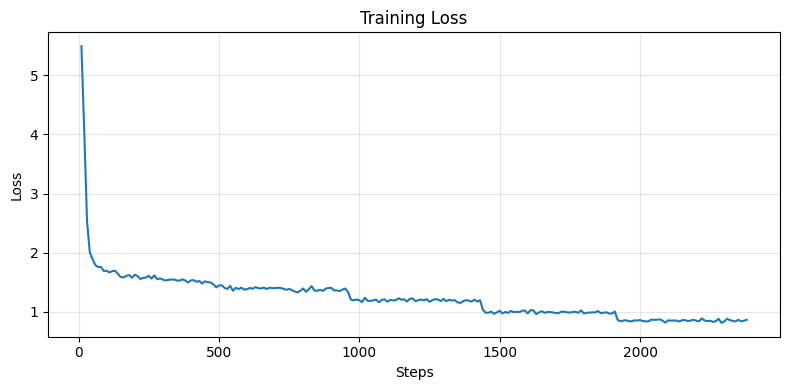

In [ ]:
import matplotlib.pyplot as plt

log_history = trainer.state.log_history
steps = [entry["step"] for entry in log_history if "loss" in entry]
losses = [entry["loss"] for entry in log_history if "loss" in entry]

plt.figure(figsize=(8,4))
plt.plot(steps, losses, linewidth=1.5)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 8. Post Training Evaluation

In [15]:
print("Running post-training evaluation.....")
test_sentences = test_dataset["tweet"]
test_labels = [LABEL_MAP[l] for l in test_dataset["sentiment"]]
finetuned_preds = run_inference(model, tokenizer, test_sentences)

Running post-training evaluation.....
Starting inference on 7619 samples...
	7619/7619 processed
7619/7619 done!


In [ ]:
print("="*50)
print("Fine-Tuned Evaluation metrics")
print("="*50)

ft_acc = accuracy_score(test_labels, finetuned_preds)
ft_f1 = f1_score(test_labels, finetuned_preds, average="weighted", labels=["neutral", "bullish", "bearish"])

print(f"\nAccuracy: {ft_acc:.4f}")
print(f"F1 (weighted): {ft_f1:.4f}")

print("\nClassification Report:")
print(classification_report(test_labels, finetuned_preds, labels=["neutral", "bullish", "bearish"]))

print("\nConfusion Matrix:")
conf_mat = confusion_matrix(test_labels, finetuned_preds, labels=["neutral", "bullish", "bearish"])
print(conf_mat)

unknown_count = finetuned_preds.count("unknown")
print(f"Unknown: {unknown_count} ({100*unknown_count/len(finetuned_preds):.1f}%)")

Fine-Tuned Evaluation metrics

Accuracy: 0.8702
F1 (weighted): 0.8701

Classification Report:
              precision    recall  f1-score   support

     neutral       0.88      0.87      0.87      2436
     bullish       0.88      0.89      0.89      3474
     bearish       0.83      0.83      0.83      1709

    accuracy                           0.87      7619
   macro avg       0.86      0.86      0.86      7619
weighted avg       0.87      0.87      0.87      7619


Confusion Matrix:
[[2109  216  111]
 [ 191 3108  175]
 [ 103  193 1413]]
Unknown: 0 (0.0%)


In [ ]:
# Baseline VS Fine-tuned
print("\n" + "="*50)
print("Comparison: Baseline vs Fine-tuned")
print("="*50)
print(f"{'Metric':<20} {'Baseline':>10} {'Fine-tuned':>12} {'Change':>10}")
print("-"*50)
print(f"{'Accuracy':<20} {baseline_accuracy:>10.4f} {ft_accuracy:>12.4f} {ft_accuracy - baseline_accuracy:>+10.4f}")
print(f"{'F1 (weighted)':<20} {baseline_f1:>10.4f} {ft_f1:}")

# 9. Save Model

In [ ]:
import os
os.getcwd()

'/content/drive/MyDrive/Fine-Tuning/Prism'

In [ ]:
model.save_pretrained("./model/financial_sentiment_lora_adapters", safe_serialization=True)
tokenizer.save_pretrained("./model/financial_sentiment_lora_adapters")
print("LoRA adapters saved!")

LoRA adapters saved!


In [ ]:
# Merge LoRA adapters with the base model and save as 16-bit safetensors
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

base_id = "Qwen/Qwen3-4B-Instruct-2507"
adapter_dir = "./model/financial_sentiment_lora_adapters"

tokenizer = AutoTokenizer.from_pretrained(adapter_dir, trust_remote_code=True)

base = AutoModelForCausalLM.from_pretrained(
    base_id,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True,
)

hf_model = PeftModel.from_pretrained(base, adapter_dir)
model = hf_model.merge_and_unload()

out_dir = "./model/Qwen3-4B-Instruct-Fine-tuned_16Bit"
hf_model.save_pretrained(out_dir, safe_serialization=True, max_shard_size="2GB")
tokenizer.save_pretrained(out_dir)
print(f"Model saved as SafeTensors at {out_dir}")

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/99.6M [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

Model saved as SafeTensors at ./model/Qwen3-4B-Instruct-Fine-tuned_16Bit


# Load Fine-Tuned Model from Directory



In [11]:
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Fine-Tuning/Prism')
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Fine-Tuning/Prism


In [12]:

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

In [13]:
MODEL_DIR = "./model/Qwen3-4B-Instruct-Fine-tuned_16Bit/"

In [14]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_DIR,
    dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True,
)
model.eval()

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.08G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

Loading adapter weights from ./model/Qwen3-4B-Instruct-Fine-tuned_16Bit/ led to missing keys in the model: model.layers.0.self_attn.q_proj.lora_A.default.weight, model.layers.0.self_attn.q_proj.lora_B.default.weight, model.layers.0.self_attn.k_proj.lora_A.default.weight, model.layers.0.self_attn.k_proj.lora_B.default.weight, model.layers.0.self_attn.v_proj.lora_A.default.weight, model.layers.0.self_attn.v_proj.lora_B.default.weight, model.layers.0.self_attn.o_proj.lora_A.default.weight, model.layers.0.self_attn.o_proj.lora_B.default.weight, model.layers.0.mlp.gate_proj.lora_A.default.weight, model.layers.0.mlp.gate_proj.lora_B.default.weight, model.layers.0.mlp.up_proj.lora_A.default.weight, model.layers.0.mlp.up_proj.lora_B.default.weight, model.layers.0.mlp.down_proj.lora_A.default.weight, model.layers.0.mlp.down_proj.lora_B.default.weight, model.layers.1.self_attn.q_proj.lora_A.default.weight, model.layers.1.self_attn.q_proj.lora_B.default.weight, model.layers.1.self_attn.k_proj.lor

Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 2560, padding_idx=151654)
    (layers): ModuleList(
      (0-35): 36 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): lora.Linear(
            (base_layer): Linear(in_features=2560, out_features=4096, bias=False)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.05, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=2560, out_features=32, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=32, out_features=4096, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
            (lora_magnitude_vector): ModuleDict()
          )
          (k_proj): lora.Linear(
            (base_layer): Linear(in_features=2560, out_features=1024, bias=False)
            (lora_dropout): ModuleDict(
  

## Quick Sanity check

In [ ]:
print("Running post-training evaluation.....")
test_sentences = test_dataset["tweet"]
test_labels = [LABEL_MAP[l] for l in test_dataset["sentiment"]]
finetuned_preds = run_inference(model, tokenizer, test_sentences)

In [16]:
messages = [
    {"role": "system", "content": "You are a finance sentiment analyst. Classify the financial news sentiment as neutral, bullish, or bearish. Respond with a single word only."},
    {"role": "user", "content": "Nvidia shares fell after guidance disappointed investors."}
]

In [17]:
prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
with torch.no_grad():
  out = model.generate(**inputs, max_new_tokens=10, do_sample=False)

print(tokenizer.decode(out[0], skip_special_tokens=True))

system
You are a finance sentiment analyst. Classify the financial news sentiment as neutral, bullish, or bearish. Respond with a single word only.
user
Nvidia shares fell after guidance disappointed investors.
assistant
bearish


# 11. DeepEval Evaluation

In [18]:
from dotenv import load_dotenv

load_dotenv()

True

In [19]:
from deepeval.metrics import GEval
from deepeval.test_case import LLMTestCase, LLMTestCaseParams
from deepeval.models import DeepEvalBaseLLM
from deepeval import evaluate
import asyncio
import requests

In [23]:
import time
import random
import re
import json
import os
from typing import Any, Optional, Type
from pydantic import BaseModel

def _extract_json_object(text: str) -> str | None:
  if not text:
    return None

  m = re.search(r"\{.*\}", text, flags=re.DOTALL)
  return m.group(0) if m else None

class OllamaAsJudge(DeepEvalBaseLLM):
  def __init__(
      self,
      model: str,
      api_key: str | None = None,
      base_url: str = "https://ollama.com",
      temperature: float = 0.0,
      generation_kwargs: Optional[dict] = None,
      force_json: bool = True,
      timeout_s: int = 120,
      max_retries: int = 5,
      max_concurrent: int = 1,
      sleep_between_calls_s: float = 0.0,
  ):
    self.model_name = model
    self.api_key = api_key or os.getenv("OLLAMA_API_KEY")
    self.base_url = base_url.rstrip("/")
    self.temperature = float(temperature)
    self.generation_kwargs = generation_kwargs or {}
    self._timeout_s = timeout_s
    self._max_retries = max_retries
    self._force_json = force_json
    self._sleep_between_calls_s = float(sleep_between_calls_s)

    if not self.api_key:
      raise ValueError("Missing OLLAMA_API_KEY. Set OLLAMA_API_KEY in .env file.")

    self._sem = asyncio.Semaphore(max_concurrent)

  def get_model_name(self) -> str:
    return f"ollama-cloud:{self.model_name}"

  def load_model(self) -> Any:
    return None

  def _request(self, payload: dict) -> dict:
    url = f"{self.base_url}/api/chat"
    headers = {
        "Authorization": f"Bearer {self.api_key}",
        "Content-Type": "application/json",
    }
    response = requests.post(url, headers=headers, json=payload, timeout=self._timeout_s)
    response.raise_for_status()
    return response.json()

  def generate(self, prompt: str, schema: Optional[Type[BaseModel]] = None):
    payload = {
        "model": self.model_name,
        "messages": [
            {
                "role": "system",
                "content": (
                    "You are a strict evaluation model that judges output of other llm models. "
                    "Return ONLY the required JSON (no markdown, no extra keys, no extra tokens)."
                ),
            },
            {"role": "user", "content": prompt},
        ],
        "stream": False,
        "options": {
            "temperature": self.temperature,
            **self.generation_kwargs,
        },
    }

    if self._force_json:
      payload["format"] = "json"

    last_err = None
    for attempt in range(self._max_retries + 1):
      try:
        data = self._request(payload)
        if isinstance(data, dict) and data.get("error"):
          raise RuntimeError(data["error"])

        content = (data.get("message") or {}).get("content")
        if not content:
          content = data.get("response", "")
        content = (content or "").strip()
        if not content:
          raise ValueError("Empty judge response")

        if schema is None:
          result = content
        else:
          try:
            result = schema.model_validate_json(content)
          except Exception:
            maybe = _extract_json_object(content)
            if maybe is None:
              raise
            result = schema.model_validate(json.loads(maybe))

        if self._sleep_between_calls_s > 0:
          time.sleep(self._sleep_between_calls_s)
        return result

      except requests.HTTPError as e:
        last_err = e
        status = getattr(e.response, "status_code", None)
        if status not in {429, 500, 502, 503, 504} or attempt == self._max_retries:
          raise

      except (requests.RequestException, ValueError, RuntimeError) as e:
        last_err = e
        if attempt == self._max_retries:
          raise

      backoff = min(10.0, 2 ** attempt) + random.uniform(0, 0.5)
      time.sleep(backoff)

    raise last_err

  async def a_generate(self, prompt: str, schema: Optional[Type[BaseModel]] = None) -> str:
    async with self._sem:
      result = await asyncio.to_thread(self.generate, prompt, schema)
      if self._sleep_between_calls_s > 0:
        await asyncio.sleep(self._sleep_between_calls_s)
      return result

In [21]:
# create test cases — sample 50 examples to keep API costs low
sample_indices = random.sample(range(len(test_sentences)), min(50, len(test_sentences)))

test_cases = []
for idx in sample_indices:
    test_cases.append(
        LLMTestCase(
            input=test_sentences[idx],
            actual_output=finetuned_preds[idx],
            expected_output=test_labels[idx],
        )
    )

print(f"Created {len(test_cases)} test cases for DeepEval")
print(f"\nExample test case:")
print(f"  Input: {test_cases[0].input[:80]}...")
print(f"  Expected: {test_cases[0].expected_output}")
print(f"  Actual: {test_cases[0].actual_output}")

Created 50 test cases for DeepEval

Example test case:
  Input: the blockchain can’t even work correctly...
  Expected: bearish
  Actual: bearish


In [25]:
JUDGE_MODEL_NAME = "deepseek-v3.1:671b-cloud"

judge = OllamaAsJudge(
    model=JUDGE_MODEL_NAME,
    temperature=0.0,
    generation_kwargs={
        "num_predict": 256,
    },
    sleep_between_calls_s=0.2,
)

sentiment_correctness = GEval(
    name="Sentiment correctness",
    criteria=(
        "Return score=1 if ACTUAL_OUTPUT exactly equals EXPECTED_OUTPUT "
        "(case-insensitive) and is one of: neutral, bullish, or bearish. "
        "Otherwise score=0. Also return a short reason."
    ),
    evaluation_params=[
        LLMTestCaseParams.INPUT,
        LLMTestCaseParams.ACTUAL_OUTPUT,
        LLMTestCaseParams.EXPECTED_OUTPUT,
    ],
    model=judge,
    strict_mode=True,
)

# Run sequentially to avoid rate limits
results = []
for i, tc in enumerate(test_cases):
  sentiment_correctness.measure(tc)
  results.append({
      "i": i,
      "score": sentiment_correctness.score,
      "reason": sentiment_correctness.reason,
  })

results[:5], len(results)

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

([{'i': 0,
   'score': 1,
   'reason': "Actual Output 'bearish' matches Expected Output 'bearish' in case-insensitive comparison and both are valid sentiment labels."},
  {'i': 1,
   'score': 0,
   'reason': 'Actual Output is neutral while Expected Output is bearish, and both are valid sentiment labels.'},
  {'i': 2,
   'score': 1,
   'reason': "Actual Output 'bullish' matches Expected Output 'bullish' in case-insensitive comparison and both are valid sentiment labels."},
  {'i': 3,
   'score': 1,
   'reason': "Actual Output 'neutral' matches Expected Output 'neutral' ignoring case and both are valid sentiment labels."},
  {'i': 4,
   'score': 1,
   'reason': "Actual Output 'neutral' and Expected Output 'neutral' match exactly ignoring case and both are valid sentiment labels."}],
 50)